# AGILE 2024 - Generation of Synthetic Data for the GIS-classroom

This notebook will reproduce the examples shown in my presentation at AGILE GIS 2024 at the University of Glasgow. Here we use `pointpats` package from `pysal` to produce a realistic looking synthetic dataset to approximate the distribution of schools in Glasgow, to be plotted side by side with a dataset of real school locations in the city. This is done by implementing multiple Poisson point processes as well as clustered point processes.

In addition we demonstrate a method for producing a synthetic set of administrative boundary polygons, given an input set of real polygons. These polygons are manipulated, through affine transformations and rotations, overlay & join operations, and some clustering, in order to produce a synthetic set of polygons.

## Package Imports

In [14]:
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import shapely
import geopandas as gpd
import pandas as pd
import random

glasgow = ps.io.open("glasgow.shp")
glasgow = shapely_ext.cascaded_union(glasgow)

# create window from Glasgow boundary
window = Window(glasgow.parts)

## Point Process Dataset

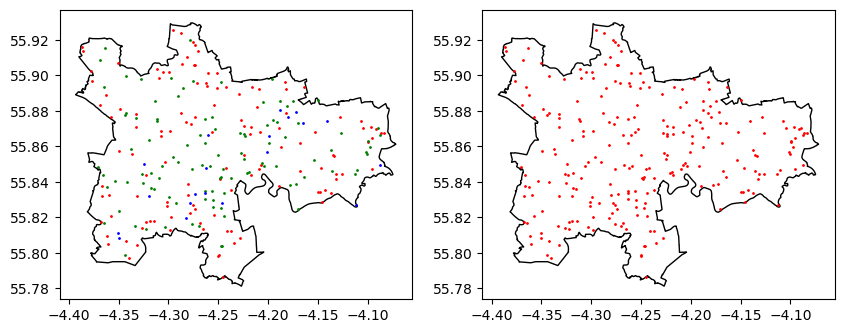

In [23]:
np.random.seed(5)
samples = PoissonPointProcess(window, 125, 1, conditioning=False, asPP=True)
csr_points = samples.realizations[0]

csamples_a = PoissonClusterPointProcess(window, 75, 5, 0.1, 1, asPP=True, conditioning=True)
cluster_points_a = csamples_a.realizations[0]

csamples_b = PoissonClusterPointProcess(window, 50, 5, 0.05, 1, asPP=True, conditioning=True)
cluster_points_b = csamples_b.realizations[0]


csr_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(csr_points.points['x'], csr_points.points['y']), crs=4326) 
cluster_a_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cluster_points_a.points['x'], cluster_points_a.points['y']), crs=4326)
cluster_b_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cluster_points_b.points['x'], cluster_points_b.points['y']), crs=4326)

glasgow_gdf = gpd.GeoSeries(glasgow)

fig, ax = plt.subplots(1,2, figsize=(10,8))

glasgow_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
csr_gdf.plot(ax=ax[0], markersize=1, color='red')
cluster_a_gdf.plot(ax=ax[0], markersize=1, color='green')
cluster_b_gdf.plot(ax=ax[0], markersize=1, color='blue')


glasgow_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
csr_gdf.plot(ax=ax[1], markersize=1, color='red')
cluster_a_gdf.plot(ax=ax[1], markersize=1, color='red')
cluster_b_gdf.plot(ax=ax[1], markersize=1, color='red')

glasgow_points_gdf = pd.concat([csr_gdf, cluster_a_gdf, cluster_b_gdf])

In [22]:
#glasgow_points_gdf.to_file("glasgow_250.geojson")

## Synthetic Polygon Manipulation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import random
import shapely

from shapely import Polygon, Point, affinity
from shapely.geometry import box, JOIN_STYLE
from shapely.ops import snap, unary_union
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from itertools import combinations
from sklearn.cluster import KMeans

In [4]:
def move_gdf(gdf_poly, gdf_dest):
    gdf_new = gdf_poly.copy()
    gdf_new['delta_x'] = gdf_dest['geometry'].x - gdf_new['geometry'].centroid.x
    gdf_new['delta_y'] = gdf_dest['geometry'].y - gdf_new['geometry'].centroid.y
    gdf_new['geometry'] = gdf_new.apply(lambda gdf: affinity.translate(gdf.loc['geometry'], xoff=gdf.loc['delta_x'], yoff=gdf.loc['delta_y']), axis=1)
    # adding in a random rotation element
    gdf_new['geometry'] = gdf_new.apply(lambda gdf: affinity.rotate(gdf.loc['geometry'], 90 * random.choice([0,1,2,3]), 'center'), axis=1)
    return gdf_new[gdf_new['geometry'].geom_type != 'Point']


def find_overlaps(gdf):
    """Returns a list of tuples identifying the geometries
    that overlap one another.
    """
    overlaps, retouch = [], {}
    for x, y in combinations(gdf.index.tolist(), 2):
        g_x = gdf.loc[x].geometry
        g_y = gdf.loc[y].geometry
        if g_x.intersects(g_y):
            overlaps.append([x, y])

    for t, b in overlaps:
        retouch.setdefault(t, []).append(b)

    return overlaps, retouch


def clip_overlaps_by_weight(gdf, col, tol=0.0000001):
    """Clips out overlapping geometries within a shapefile
    ranked by an attribute.
    """

    gdf.sort_values(by=col, axis=0, ascending=False, inplace=True)
    gdf.reset_index(drop=True, inplace=True)
    dupd = gdf.geometry.duplicated()
    if dupd.any():  # keep highest weighted duplicate, remove the rest
        gdf = gdf.loc[~dupd]

    overlaps, retouch = find_overlaps(gdf)

    for overlap in overlaps:
        top, bot = gdf.loc[overlap].geometry
        try:
            bot = bot.difference(top)
        except:
            breakpoint()
        top = snap(top, bot, tol)
        gdf.loc[overlap, "geometry"] = gpd.GeoSeries([top, bot], index=overlap)

    for clipper, clip_list in retouch.items():
        for clipped in clip_list[:-1]:
            top, bot = gdf.loc[[clipper, clipped]].geometry
            gdf.loc[clipped, "geometry"] = snap(bot, top, tol)

    return gdf#.sort_values(by="index").drop("index", axis=1)

def multi_to_poly(gdf):
    polys = []
    for geom in gdf.geometry:
        if isinstance(geom, shapely.geometry.multipolygon.MultiPolygon):
            for y in geom.geoms:
                polys.append(y)
        else:
            polys.append(geom)
    return gpd.GeoDataFrame(geometry=polys, crs=3857)#.reset_index(drop=True)

def poly_bb_ratio(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    bb = gpd.GeoSeries(box(min_x, min_y, max_x, max_y, ccw=True))
    ratio = float(1/(poly.area/bb.area))
    if ratio < 1.8:
        return 1.8
    return ratio

def points_uniform(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    poly_ratio = poly_bb_ratio(poly)
    poly_gdf = gpd.GeoDataFrame(pd.DataFrame([poly], columns=['geometry']), geometry='geometry', crs=3857)

    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < round(num_points * poly_ratio):
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))
    gdf = gpd.GeoDataFrame(pd.DataFrame(points, columns=['geometry']), geometry='geometry', crs=3857)
    gdf = gdf.sjoin(poly_gdf, predicate='within').drop(['index_right'], axis=1)
    #gdf = gdf.drop(['index_right'], axis=1)
    return gdf.iloc[0:num_points].reset_index(drop=True)

def kmeans_polys(num_cluster, polys):
    # The geometries of the Shapely points are converted to a numpy array for use in the kmeans algorithm
    feature_coords = np.array([[e.x, e.y] for e in polys.centroid.geometry])

    # A kmeans object is created using the specified number of clusters
    kmeans = KMeans(num_cluster)
    kmeans.fit(feature_coords)

    # The cluster centres are stored as centroids, and this list is put into a GeoDataFrame and returned

    gdf = gpd.GeoDataFrame(pd.DataFrame(kmeans.labels_, columns=['cluster']), geometry=polys.geometry)

    return gdf

def kmeans_centroids(poly, num_cluster, num_points=500):
    # Points are generated randomly in the polygon
    source = points_uniform(poly, num_points)  
    # The geometries of the Shapely points are converted to a numpy array for use in the kmeans algorithm
    feature_coords = np.array([[e.x, e.y] for e in source.geometry])

    # A kmeans object is created using the specified number of clusters
    kmeans = KMeans(num_cluster)
    kmeans.fit(feature_coords)

    # The cluster centres are stored as centroids, and this list is put into a GeoDataFrame and returned
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
    return gdf

def voronoi_gen(poly, vor_num):
    vor_centroids = kmeans_centroids(poly.geometry[0], vor_num)
    boundary_shape = unary_union(poly)
    boundary_shape = poly.unary_union
    coords = points_to_coords(vor_centroids.geometry)

    # Calculating the voronoi regions
    region_polys, _ = voronoi_regions_from_coords(coords, boundary_shape)

    df = pd.DataFrame(list(region_polys.items()), columns=['index','geometry'])
    gdf_poly = gpd.GeoDataFrame(df, geometry='geometry', crs=3857)
    return gdf_poly.drop('index', axis=1)

def shuffled_polys(poly_input, num_polys, how='swap', crs=3857):
    poly_bounds = gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly_input.unary_union, crs=crs))
    
    if how == 'kmeans':
        new_centroids = kmeans_centroids(poly_bounds.geometry[0], num_polys)
    elif how == 'swap':
        new_centroids = gpd.GeoDataFrame(pd.DataFrame(poly_input['geometry'].centroid.reset_index(drop=True), columns=['geometry']).sample(len(poly_input)).reset_index(drop=True), geometry='geometry')
    else:
        new_centroids = gpd.GeoDataFrame(pd.DataFrame(poly_input['geometry'].centroid.reset_index(drop=True), columns=['geometry']).sample(len(poly_input)).reset_index(drop=True), geometry='geometry')
    
    poly_moved = move_gdf(poly_input, new_centroids)

    #overlay1 = gpd.GeoDataFrame(geometry=poly_bounds).overlay(poly_moved, how='union')
    #overlay = gpd.GeoDataFrame(geometry=poly_bounds).overlay(overlay1, how='intersection')

    overlay = poly_bounds.overlay(poly_bounds.overlay(poly_moved, how='union'), how='intersection').reset_index(names='index')


    test = clip_overlaps_by_weight(overlay, 'index')
    test_polys = multi_to_poly(test)
    test_polys = test_polys[~test_polys.geometry.is_empty]  

    kmeans_out = kmeans_polys(num_polys, test_polys).sort_values('cluster').reset_index(drop=True)
    return kmeans_out.dissolve(by='cluster', as_index=False)

In [31]:
seed = random.randint(0,10000)
np.random.seed(seed)

# 1326
print("random seed:", seed)

glasgow = gpd.read_file("geojson/glasgow.geojson").to_crs(3857)
glasgow_pd = gpd.read_file("geojson/glasgow_polling_districts.geojson").to_crs(3857)
# adding a minor buffering to the bounds to avoid artifacts in the union

glasgow_voronoi = voronoi_gen(glasgow, len(glasgow_pd))
glasgow_shuffle = shuffled_polys(glasgow, len(glasgow), how='kmeans')

glasgow_voronoi.to_file("geojson/glasgow_voronoi.geojson")

random seed: 4789


C:\Users\Paddy\AppData\Local\Temp\ipykernel_12448\2312637977.py:70: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ratio = float(1/(poly.area/bb.area))
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Axes: title={'center': 'Voronoi'}>

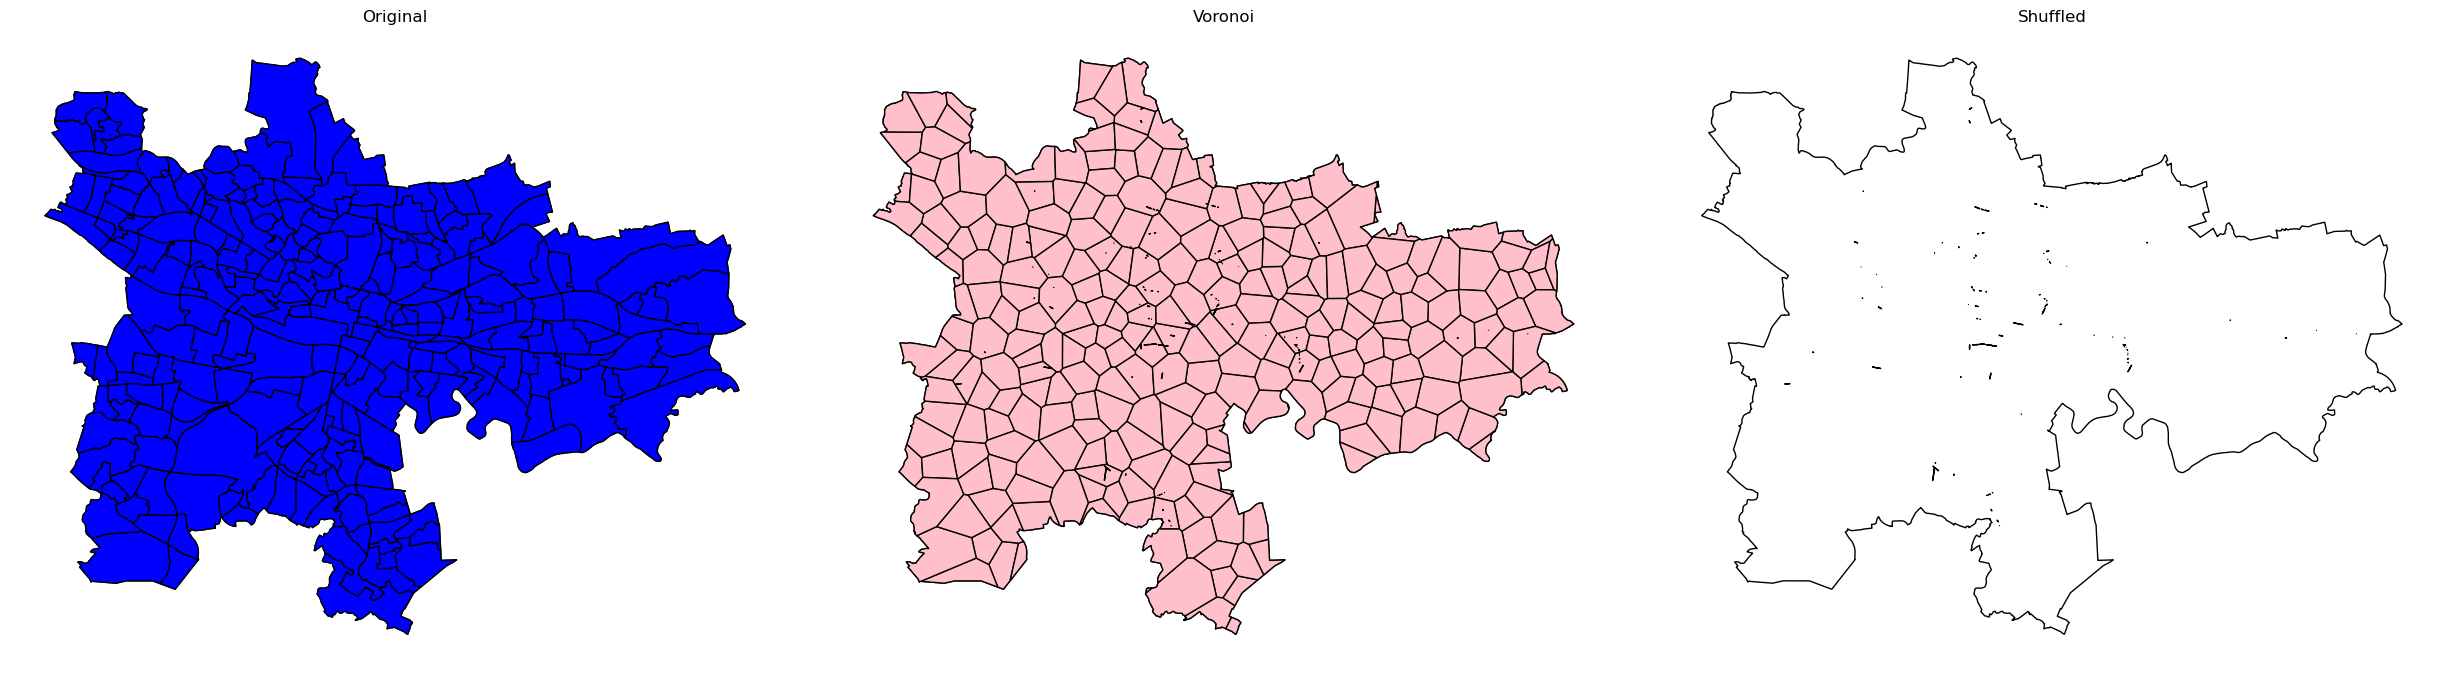

In [25]:
fig, ax = plt.subplots(1,3, figsize=(25,12))
sub_titles = ['Original', 'Voronoi', 'Shuffled']
fig.tight_layout()

for i, x in enumerate(ax):
    glasgow_bounds.plot(ax=x, edgecolor='black', facecolor='none')
    x.set_title(sub_titles[i])
    x.set_axis_off()

glasgow.plot(ax=ax[0], edgecolor='black', facecolor='blue')
glasgow_voronoi.plot(ax=ax[1], edgecolor='black', facecolor='pink')
glasgow_shuffle.plot(ax=ax[2], edgecolor='black', facecolor='green')


random seed: 9020


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 114 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returne

<Axes: >

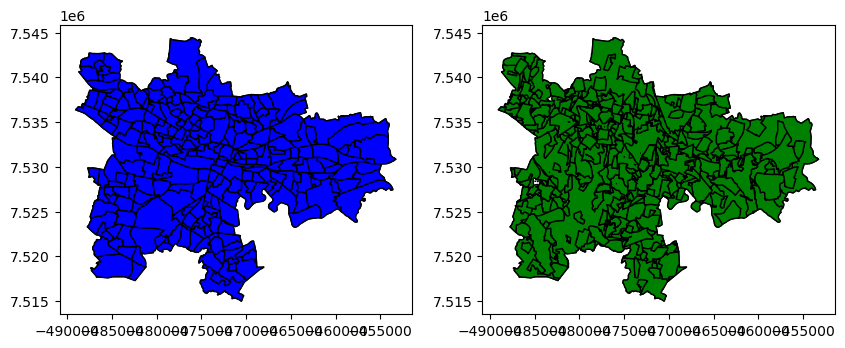

In [13]:
seed = random.randint(0,10000)
np.random.seed(seed)

# 1326
print("random seed:", seed)

glasgow = gpd.read_file("glasgow_polling_districts.geojson").to_crs(3857)
glasgow_bounds = gpd.GeoSeries(glasgow.unary_union, crs=3857)

glasgow_shuffle = shuffled_polys(glasgow, len(glasgow), how='swap')

fig, ax = plt.subplots(1,2, figsize=(10,8))

for x in ax:
    glasgow_bounds.plot(ax=x, edgecolor='black', facecolor='none')

glasgow.plot(ax=ax[0], edgecolor='black', facecolor='blue')
glasgow_shuffle.plot(ax=ax[1], edgecolor='black', facecolor='green')

## Road buffering example - Glasgow suburb

In [47]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import time
import pandas as pd

from shapely.geometry import Point, Polygon

### Query OSM to collect road, railway, and river data for the given region

/tmp/ipykernel_12912/4234994945.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(poly.area)


0    0.00004
dtype: float64


<Axes: >

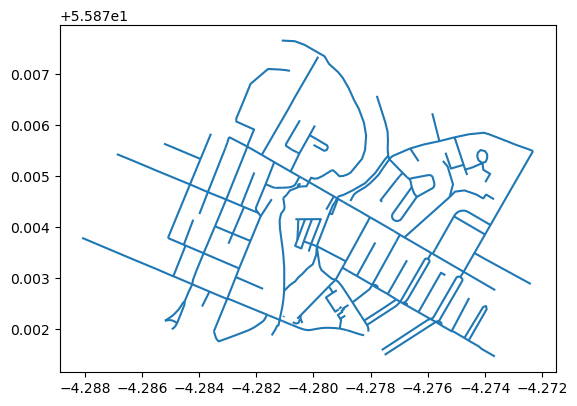

In [42]:
poly = gpd.read_file("geojson/glasgow_kelvin.geojson")#.to_crs(3857)#.buffer(3000,join_style=2).to_crs(4326))

print(poly.area)
# features_from_bbox takes bbox as [north, south, east, west]
# so a reorder of total_bounds is needed (it goes minx, miny, maxx, maxy)
bb = poly.total_bounds
bb[0], bb[1], bb[2], bb[3] = bb[3], bb[1], bb[2], bb[0] 

tags = {"highway" : True}
#tags = {"highway" : True, "railway" : True, "waterway" : True}
ways = ox.features_from_bbox(bbox=bb, tags=tags)
ways = ways.loc[ways.geometry.type=='LineString']
ways = ways.loc[ways.highway!="footway"]
ways.plot()

### Clip the road data to the region bounding box and generate buffers on the roads

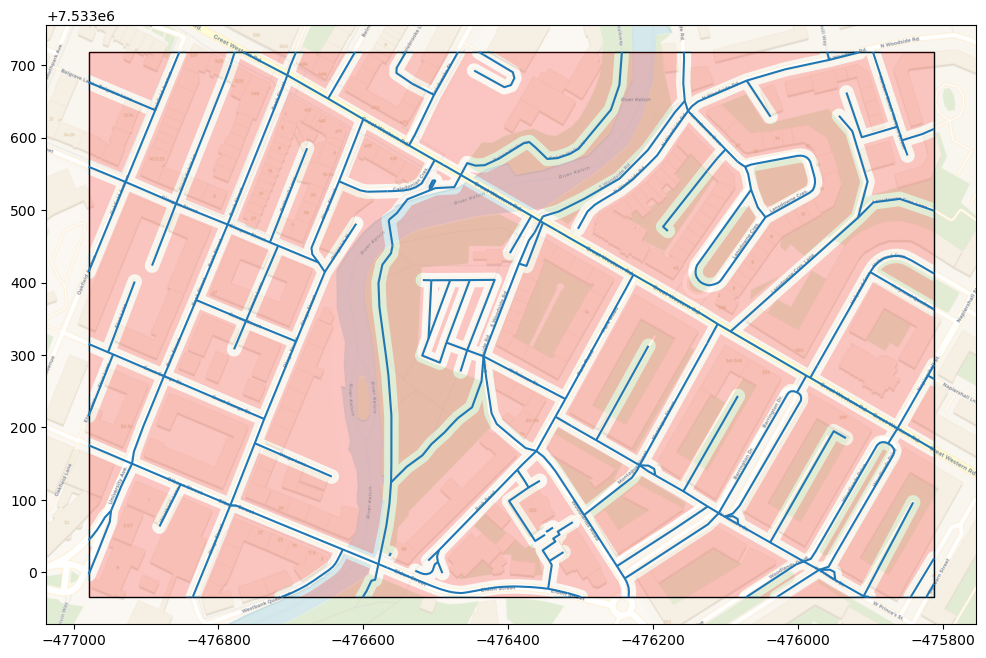

In [43]:
poly = poly.to_crs(3857)
ways = ways.to_crs(3857)

ways_clip = gpd.clip(ways, poly)

ways_buffer = gpd.GeoDataFrame(geometry=ways_clip.buffer(10))

ways_poly = poly.overlay(ways_buffer, how='symmetric_difference')
ways_poly = gpd.clip(ways_poly, poly)
#ways_poly = poly.symmetric_difference(ways_buffer)

fig, ax = plt.subplots(1,1,figsize=(12,8))

poly.plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

ways_clip.plot(ax=ax)
ways_poly.plot(ax=ax, facecolor='red', alpha=0.2)
plt.show()

### Buffering the resulting polygons to produce regions where buildings can appear

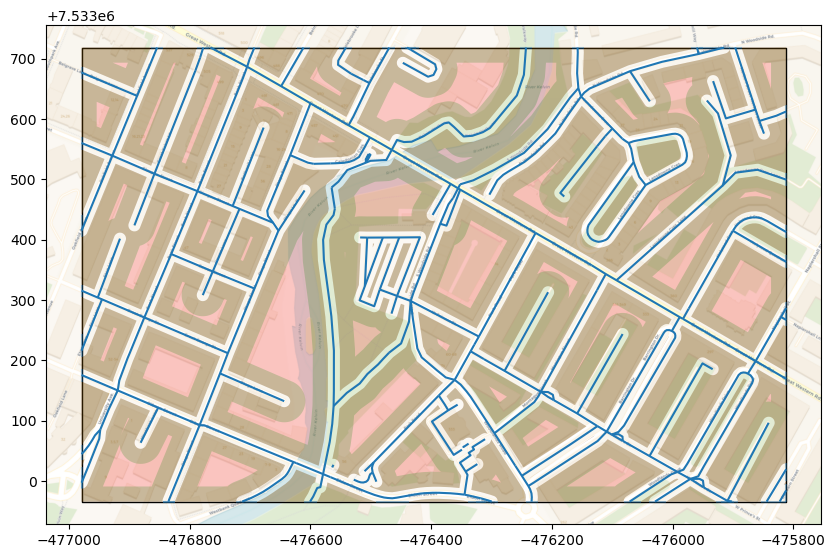

In [45]:
zone_buffer = ways_poly.buffer(-25)
stage_two = ways_poly.symmetric_difference(zone_buffer)

fig, ax = plt.subplots(1,1, figsize=(10,8))

poly.plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

ways_clip.plot(ax=ax)
ways_poly.plot(ax=ax, facecolor='red', alpha=0.2)
stage_two.plot(ax=ax, facecolor='green', alpha=0.2)
plt.show()

### Overlaying a tiled grid on the newly generated buffers

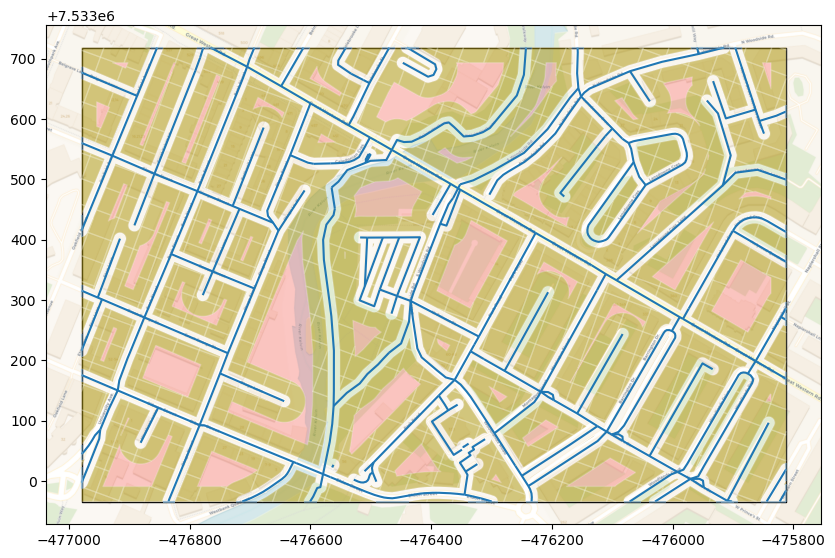

In [50]:
def square_origin(origin, side):
    #z = np.sqrt(area)/2
    z = side/2
    ox, oy = origin.x, origin.y
    return Polygon([(ox-z,oy-z),(ox-z,oy+z), (ox+z, oy+z), (ox+z, oy-z)])

def get_shape_bounds(shape):
    if isinstance(shape, gpd.geodataframe.GeoDataFrame) or isinstance(shape, gpd.geoseries.GeoSeries):
        return shape.total_bounds
    else:
        return shape.bounds

def get_bounds_angle(shape):
    minx, miny, maxx, maxy = get_shape_bounds(shape)
    ox, oy = shape.centroid.x, shape.centroid.y
    w = maxx - minx
    h = maxy - miny

    bb_poly = Polygon([(minx,miny),(minx, maxy),(maxx, maxy),(minx, maxy)])

    points_list = [shapely.Point(x) for x in bb_poly.boundary.coords]
    points_list = points_list[:-1]

    point_a = points_list[0]
    point_b = points_list[2]

    dist = point_a.distance(point_b)

    theta = np.arcsin(h/dist)
    return theta * 180/np.pi

def tile_squares(shape, side, angle):
    ox, oy = shape.centroid.x, shape.centroid.y
    minx, miny, maxx, maxy = get_shape_bounds(shape.rotate(angle, origin=Point([ox,oy])))
    w = maxx - minx
    h = maxy - miny

    ratio = w/h

    # if ratio > 1: wider than tall
    # if ratio <1 : taller than wide
    x_ratio = y_ratio = (ratio + 2)

    if ratio > 1:
        x_ratio /= 2
    else:
        y_ratio /= 2

    grid_x = int(x_ratio * np.ceil(w/side)) + 1
    grid_y = int(y_ratio * np.ceil(h/side)) + 1

    w_offset = abs(w - (side * grid_x))
    h_offset = abs(h - (side * grid_y))

    x = ox - (w/2 + w_offset/2) + side/2
    y = oy - (h/2 + h_offset/2) + side/2

    square_list = []
    for i in range(grid_x):
        for j in range(grid_y):
            origin = Point([x + (i*side), y + (j*side)])
            square_list.append(square_origin(origin, side))

    squares = gpd.GeoDataFrame(pd.DataFrame(square_list, columns=['geometry']), geometry='geometry')
    squares_rotate = gpd.GeoDataFrame(geometry=squares.rotate(angle, origin=Point([ox,oy])), crs=shape.crs) 
    return shape.overlay(squares_rotate, how='intersection',keep_geom_type=False)

def tile_gdf(gdf, size, angle):
    gdf_out = gpd.GeoDataFrame(pd.DataFrame([], columns=['geometry']),geometry='geometry')
    gdf_list = [gdf.iloc[[x]] for x in range(gdf.shape[0])]
    for x in gdf_list:
        gdf_out = pd.concat([gdf_out,tile_squares(x, size, angle)], ignore_index=True)
    return gdf_out

grid_overlay = tile_gdf(gpd.GeoDataFrame(geometry=stage_two), 40, -20)

fig, ax = plt.subplots(1,1, figsize=(10,8))

poly.plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

ways_clip.plot(ax=ax)
ways_poly.plot(ax=ax, facecolor='red', alpha=0.2)
stage_two.plot(ax=ax, facecolor='green', alpha=0.2)
grid_overlay.plot(ax=ax, facecolor='yellow', edgecolor='white', alpha=0.2)

plt.show()


### Buffering the tile grid to provide seperation between them

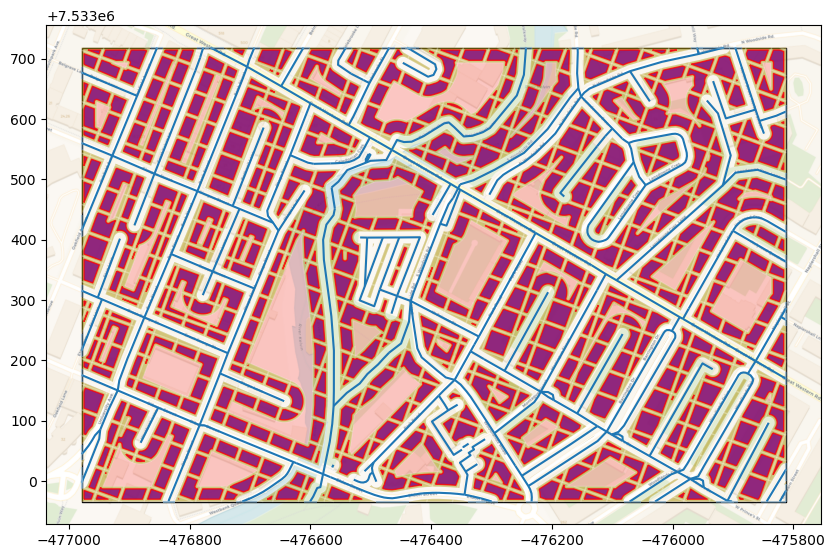

In [52]:
grid_buffer = grid_overlay.buffer(-4)
grid_buffer = grid_buffer[grid_buffer.is_empty == False].reset_index(drop=True)

fig, ax = plt.subplots(1,1, figsize=(10,8))

poly.plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

ways_clip.plot(ax=ax)
ways_poly.plot(ax=ax, facecolor='red', alpha=0.2)
stage_two.plot(ax=ax, facecolor='green', alpha=0.2)
grid_overlay.plot(ax=ax, facecolor='yellow', edgecolor='white', alpha=0.2)
grid_buffer.plot(ax=ax, facecolor='purple', edgecolor='red', alpha=0.8)

plt.show()

### Sample the "building" polygons to add variation

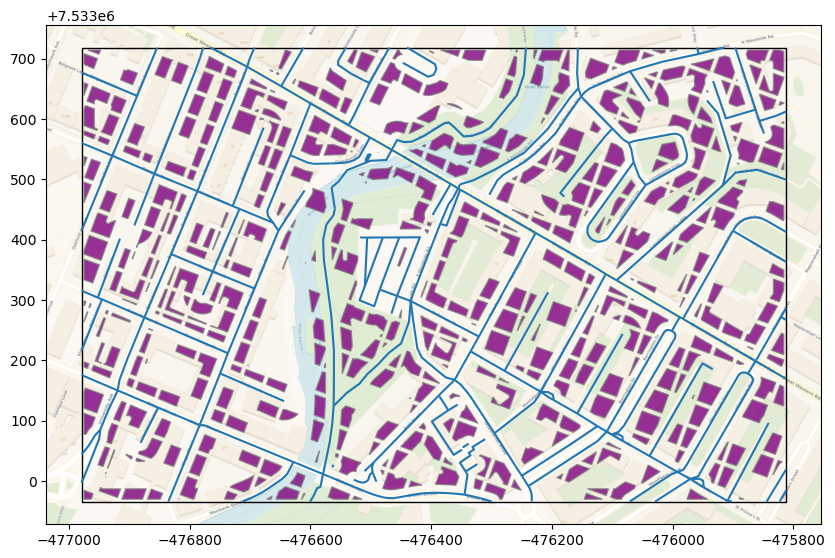

In [54]:
# Sample 75% of the generated "buildings"
synth_buildings = grid_buffer.sample(round(len(grid_buffer) * 0.75))

fig, ax = plt.subplots(1,1, figsize=(10,8))

poly.plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

ways_clip.plot(ax=ax)
synth_buildings.plot(ax=ax, edgecolor='grey', facecolor='purple', alpha=0.8)

plt.show()